## Assignment 3: применение feature importance в процессной аналитике  ( max 15 pts.)

Одна из основных задач process mining - сформировать список гипотез ("инсайтов", "неэффективностей"), оценить их важность и смоделировать что будет, если улучшить процесс по этим гипотезам

Такую работу можно выполнять разными способами - начиная от классических опросов и заканчивая подходами, основанными на данных - feature improtance, MCMC, reinforcement learning. <br>
В этом задании вам предагается опробовать базовый метод, основанный на feature importance.

<b>Постановка задачи:</b> <ol> 
    <li> Для входных данных {id, status, datetime, document_type} расcчитать время выполнения процесса {id: total_time} </li>
    <li> Для каждого id сформировать все возможные переходы по процессу {id: (st1, st), ..., (st_n-1, st_n)} </li>
    <li> Натренировать любую модель машинного обучения, где фичи - все возможные переходы и атрибуты (в нашем случае - только document_type) </li>
    <li> Оценить важность каждого перехода c помощью алгоритмов permutation importance и SHAP </li>
    <li> Сделать вывод о том, какие переходы влияют больше всего на длительность процесса (список top-5)</li>
    <li> Предположить на сколько снизится время процесса (в среднем), если их устранить - написать заключение в свободной форме </li>
 </ol>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
import time
import tqdm
from datetime import timedelta
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.tree import export_graphviz, plot_tree
%matplotlib inline

In [ ]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler

In [ ]:
def zipsort_top(vals, labels, topk=5):
    vals, labels = zip(*sorted(zip(vals, labels), key = lambda t: t[0]))
    return vals[-topk:], labels[-topk:]

### 1. Загрузим данные и трансформируем датасет

##### Можно использовать оригинальный датасет

In [ ]:
# df_raw = pd.read_csv('df_assignment2.csv', sep=';') # Читаем данные
# df_raw['DataTime'] = pd.to_datetime(df_raw['DataTime']).fillna(0) # Дата должна быть датой
# df_raw = df_raw.sort_values(['PID', 'DataTime', 'Status_Name']) # Сортируем от самых старых events к самым новым, доп. сортировка по status для стабильности

##### Либо подготовленный

In [ ]:
df = pd.read_csv('df_2_processed.csv') # Читаем данные
df_val = pd.read_csv('df_2_processed_val_public.csv') # Читаем данные
#df_test = pd.read_csv('df_2_processed_val_private.csv')

In [ ]:
df = df[(df.TotalTime<300) & (df.TotalTime>0.01)]
df_val = df_val[(df_val.TotalTime<300) & (df_val.TotalTime>0.01)]

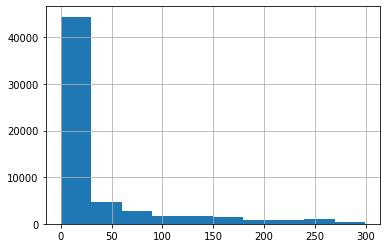

In [ ]:
df.TotalTime.hist()

In [ ]:
df['TotStat'] = df.iloc[:, 5:-1].sum(axis=1)
df_val['TotStat'] = df_val.iloc[:, 5:-1].sum(axis=1)

### ПРИМЕР: Обучим RandomForestRegressor и посчитаем feature importance (gain)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df_trees = deepcopy(df) 
for col in df_trees.columns:
#     if df_trees[col].dtype == 'object':
        le = LabelEncoder()
        le_fit = le.fit(df_trees[col].append(df_val[col]))
        df_trees[col] = le.transform(df_trees[col])
        df_val[col] = le.transform(df_val[col])

In [ ]:
y = df_trees['TotalTime']
X = df_trees.drop(['TotalTime', 'PID'], axis=1).fillna(-1)
X_names = df_trees.drop(['TotalTime', 'PID'], axis=1).columns

In [ ]:
y_val = df_val['TotalTime']
X_val = df_val.drop(['TotalTime', 'PID'], axis=1).fillna(-1)

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.01, max_depth=6)
rfr.fit(X, y)

RandomForestRegressor(max_depth=6, min_impurity_decrease=0.01)

In [ ]:
print(f'RMSE for rfr: {np.sqrt(mean_squared_error(y, rfr.predict(X))):.4f}')
print(f'RMSE for rfr Val: {np.sqrt(mean_squared_error(y_val, rfr.predict(X_val))):.4f}')

RMSE for rfr: 5276.7171
RMSE for rfr Val: 5281.6484


<BarContainer object of 10 artists>

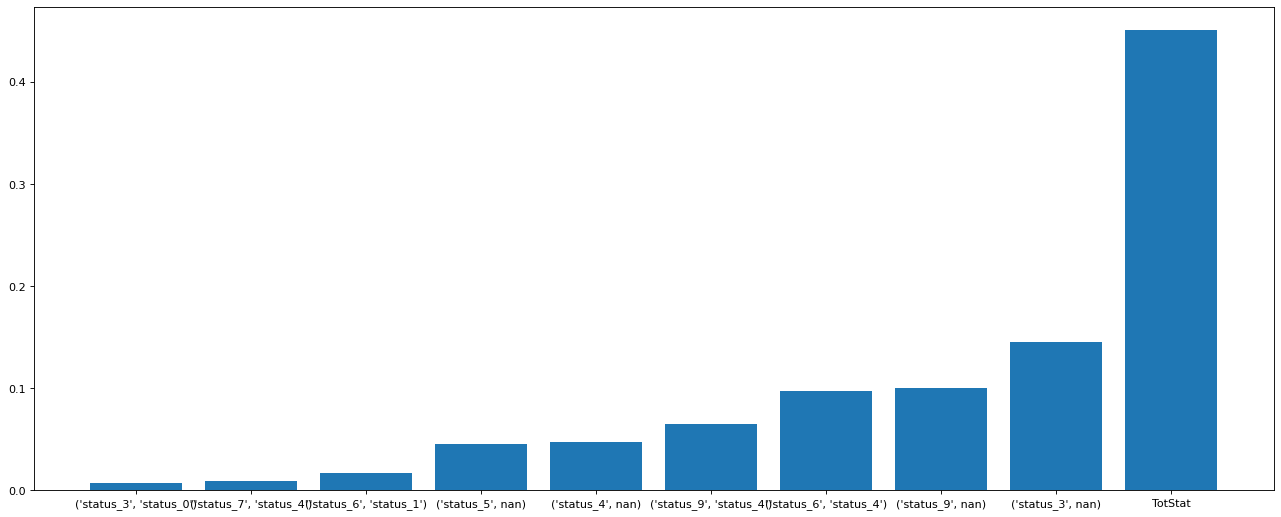

In [ ]:
importances = rfr.feature_importances_
importances, names_viz = zipsort_top(importances, X_names, 10)
figure(figsize=(20, 8), dpi=80)
plt.bar(names_viz, height=importances)

### ПРИМЕР: XGB и посчитаем feature importance (gain)

In [ ]:
import tqdm.auto
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [ ]:
gbm = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, reg_alpha=3, max_depth=3, subsample=0.8)
gbm.fit(X, y)

[11:41:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=300, reg_alpha=3, subsample=0.8)

In [ ]:
print(f'RMSE for rfr: {np.sqrt(mean_squared_error(y, gbm.predict(X))):.4f}')
print(f'RMSE for rfr Val: {np.sqrt(mean_squared_error(y_val, gbm.predict(X_val))):.4f}')

RMSE for rfr: 4932.9861
RMSE for rfr Val: 4984.8888


<BarContainer object of 10 artists>

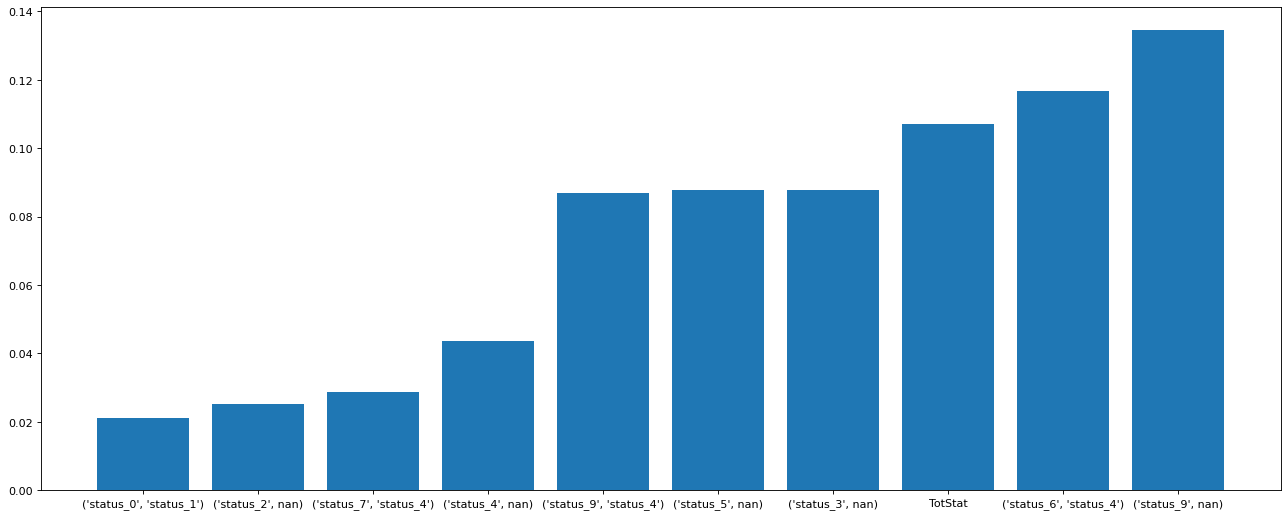

In [ ]:
importances = gbm.feature_importances_
importances, names_viz = zipsort_top(importances, X_names, 10)
figure(figsize=(20, 8), dpi=80)
plt.bar(names_viz, height=importances)

####Обучение модели

In [ ]:
df.head()

,PID,Channel,Product_Name,TID,Gender,"('status_6', nan)","('status_4', 'status_5')","('status_1', 'status_2')","('status_5', 'status_6')","('status_2', 'status_4')",...,"('status_7', 'status_5')","('status_4', 'status_6')","('status_9', 'status_6')","('status_6', 'status_6')","('status_7', 'status_9')","('status_8', 'status_4')","('status_7', 'status_3')","('status_6', 'status_3')",TotalTime,TotStat
0,-9223099799969338508,channel_1,product_2,tid_338,1.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,5.0153,7
1,-9222779103723446344,channel_2,product_0,tid_290,1.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.1056,8
2,-9222578230863541198,channel_1,product_2,tid_837,1.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0.1924,7
3,-9222555513019670885,channel_1,product_7,tid_364,0.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,246.8410,8
4,-9222528699404486344,channel_1,product_0,tid_549,1.0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,60.4507,7


In [ ]:
df_val.head()

,PID,Channel,Product_Name,TID,Gender,"('status_6', nan)","('status_4', 'status_5')","('status_1', 'status_2')","('status_5', 'status_6')","('status_2', 'status_4')",...,"('status_7', 'status_5')","('status_4', 'status_6')","('status_9', 'status_6')","('status_6', 'status_6')","('status_7', 'status_9')","('status_8', 'status_4')","('status_7', 'status_3')","('status_6', 'status_3')",TotalTime,TotStat
0,59593,0,2,47,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,8227,2
1,59594,0,0,59,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,11418,3
2,59595,1,0,70,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,20,2
3,59596,0,0,64,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,526,5
4,59597,0,2,64,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,87,2


Будем обучать XGBRegressor, оптимизируя глубину дерева. На сетке не стал делать, т.к. обучалось долго

In [ ]:
df = pd.read_csv('df_2_processed.csv')
df_val = pd.read_csv('df_2_processed_val_public.csv')

In [ ]:
y2 = df['TotalTime'].to_numpy()
X2 = df.iloc[:, 5:-2].fillna(0).to_numpy()
X_names2 = df.iloc[:, 5:-2].columns

In [ ]:
y_val2 = df_val['TotalTime'].to_numpy()
X_val2 = df_val.iloc[:, 5:-2].fillna(0).to_numpy()

In [ ]:
'''xgb1 = xgb.XGBRegressor()
parameters = { 
              'reg_alpha':[1, 3],
              'learning_rate': [.05, .07], 
              'max_depth': np.arange(4,7),
              'n_estimators': np.arange(200, 401, 100)
              }

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 4,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(X2, y2)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)'''

"xgb1 = xgb.XGBRegressor()\nparameters = { \n              'reg_alpha':[1, 3],\n              'learning_rate': [.05, .07], \n              'max_depth': np.arange(4,7),\n              'n_estimators': np.arange(200, 401, 100)\n              }\n\nxgb_grid = GridSearchCV(xgb1,\n                        parameters,\n                        cv = 4,\n                        n_jobs = 4,\n                        verbose=True)\n\nxgb_grid.fit(X2, y2)\n\nprint(xgb_grid.best_score_)\nprint(xgb_grid.best_params_)"

In [ ]:
train_loss = []
test_loss = []
for depth in tqdm.tqdm(range(4,8)):
    gbm = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, reg_alpha=3, max_depth=depth, subsample=0.8, n_jobs=4)
    gbm.fit(X2,y2)
    train_loss.append(np.sqrt(mean_squared_error(y2, gbm.predict(X2))))
    test_loss.append(np.sqrt(mean_squared_error(y_val2, gbm.predict(X_val2))))

  0%|          | 0/4 [00:00<?, ?it/s]

[14:47:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 25%|██▌       | 1/4 [00:42<02:07, 42.55s/it]

[14:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 2/4 [01:40<01:43, 51.68s/it]

[14:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 75%|███████▌  | 3/4 [02:55<01:02, 62.21s/it]

[14:50:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 4/4 [04:07<00:00, 61.99s/it]


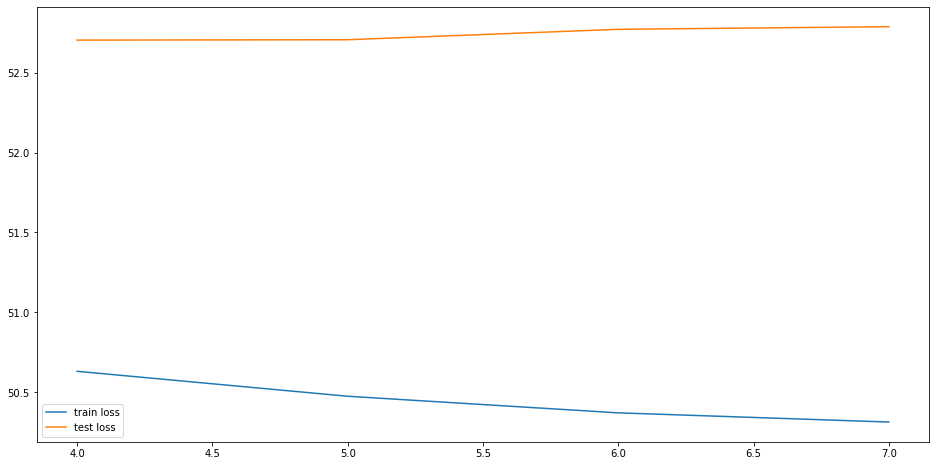

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(4,8), train_loss, label='train loss')
plt.plot(np.arange(4,8), test_loss, label='test loss')
plt.legend()
plt.show()

In [ ]:
np.argmin(test_loss)

0

In [ ]:
model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, reg_alpha=3, max_depth=4, subsample=0.8, n_jobs=4)
model.fit(X2,y2)
print(f'RMSE for rfr: {np.sqrt(mean_squared_error(y2, model.predict(X2))):.4f}')
print(f'RMSE for rfr Val: {np.sqrt(mean_squared_error(y_val2, model.predict(X_val2))):.4f}')


[15:01:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for rfr: 50.6312
RMSE for rfr Val: 52.7041


####Feature importance

Оценим  permutation importance признаков модели и также выделим топ-10


In [ ]:
perm_res = sorted(zip(permutation_importance(model, X_val2, y_val2)["importances_mean"], X_names2), reverse=True)


In [ ]:
perm_res[:10]

[(0.10748529929550514, "('status_0', 'status_1')"),
 (0.08964684714648388, "('status_6', 'status_4')"),
 (0.07974999457199095, "('status_6', nan)"),
 (0.060503725505340264, "('status_6', 'status_0')"),
 (0.044964946809441096, "('status_7', 'status_4')"),
 (0.0368766305099711, "('status_2', 'status_3')"),
 (0.0316020378978636, "('status_7', 'status_1')"),
 (0.030135123293248432, "('status_9', 'status_4')"),
 (0.028298592562536105, "('status_7', 'status_0')"),
 (0.021328169440887935, "('status_3', nan)")]

<BarContainer object of 10 artists>

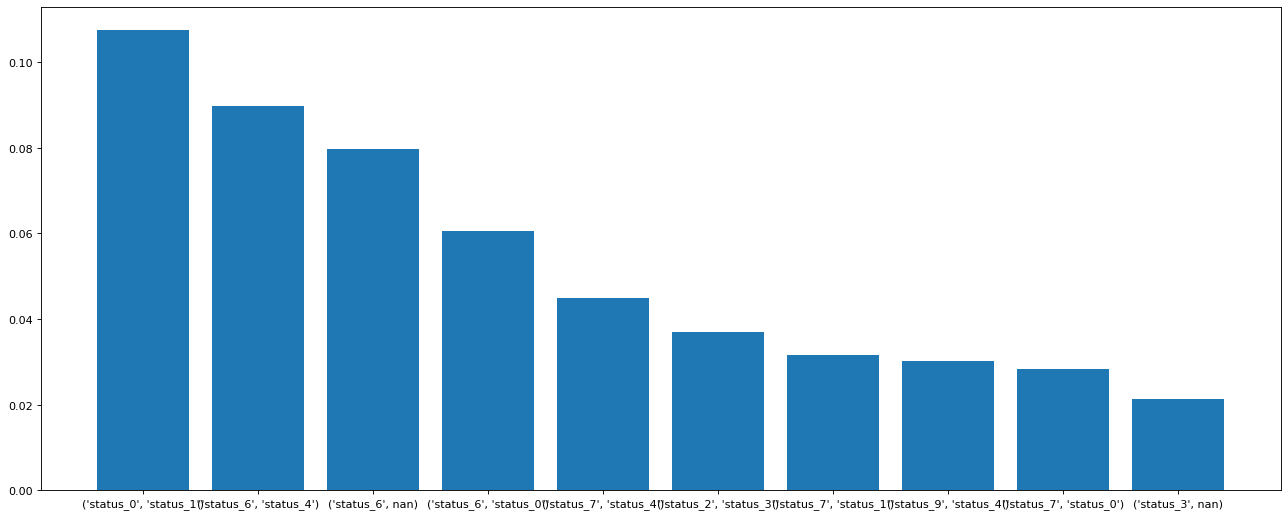

In [ ]:
figure(figsize=(20, 8), dpi=80)
plt.bar(list(x[1] for x in perm_res[:10]), height=list(x[0] for x in perm_res[:10])) #height

Посмотрим также на SHAP

In [ ]:
import shap

In [ ]:
shap_res = shap.TreeExplainer(model).shap_values(X_val2)

In [ ]:
shap_res2 = sorted(zip(np.mean(abs(shap_res), axis=0), X_names2), reverse=True)

<BarContainer object of 10 artists>

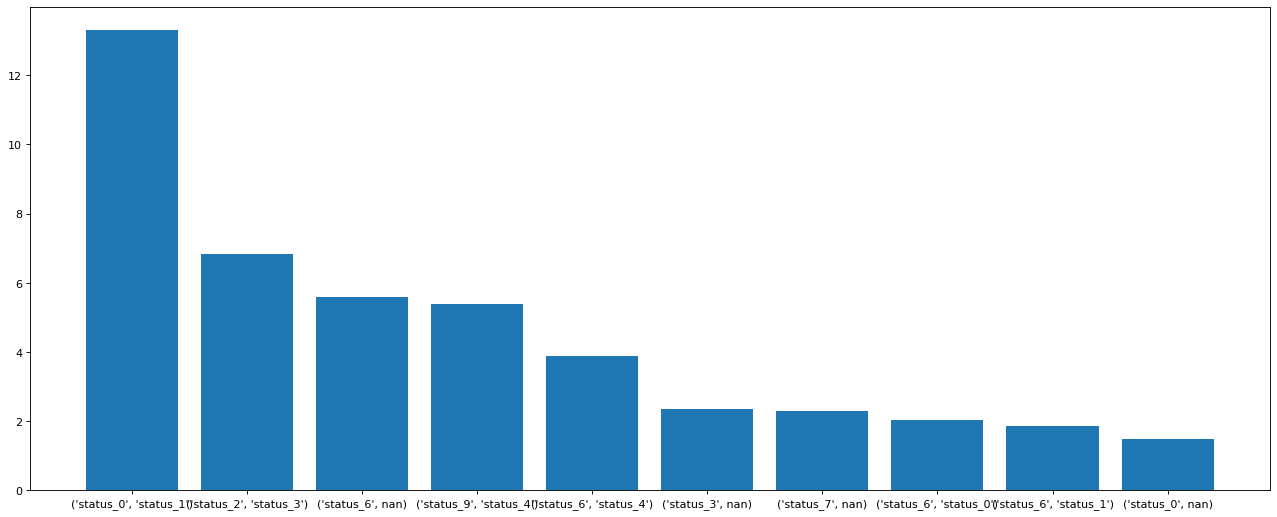

In [ ]:
figure(figsize=(20, 8), dpi=80)
plt.bar(list(x[1] for x in shap_res2[:10]), height=list(x[0] for x in shap_res2[:10]))

Наиболее значимые переходы находим,сравнивая суммы полученных значений pemutation и shap

In [ ]:
hardest = {}
for el in shap_res2:
    hardest[el[1]] = 0


for el in perm_res:
    hardest[el[1]] = 0

for elem in perm_res:
    hardest[elem[1]] += elem[0]

for elem in shap_res2:
    hardest[elem[1]] += elem[0]

In [ ]:
hard5 = zipsort_top(list(hardest.values()), list(hardest.keys()))
hard5

((3.965107471841308,
  5.413399188082066,
  5.679726534183807,
  6.876070928300498,
  13.408208375162204),
 ("('status_6', 'status_4')",
  "('status_9', 'status_4')",
  "('status_6', nan)",
  "('status_2', 'status_3')",
  "('status_0', 'status_1')"))

####Ускорение процесса

In [ ]:
X_new = df.iloc[:, 5:-2].fillna(0).drop([str(x) for x in hard5[1]], axis=1).to_numpy()  #X2.drop([hard5[1]], axis=1)
X_val_new = df_val.iloc[:, 5:-2].fillna(0).drop([str(x) for x in hard5[1]], axis=1).to_numpy()
y_new = y2
y_val_new = y_val2

In [ ]:
model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, reg_alpha=3, max_depth=4, subsample=0.8, n_jobs=4)
model.fit(X_new,y_new)
print(f'RMSE for rfr: {np.sqrt(mean_squared_error(y_new, model.predict(X_new))):.4f}')
print(f'RMSE for rfr Val: {np.sqrt(mean_squared_error(y_val_new, model.predict(X_val_new))):.4f}')

[15:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE for rfr: 53.0620
RMSE for rfr Val: 55.4824


In [ ]:
print(f"При удалении 5 самых длительных процессов в среднем время процесса снизится на \
{np.mean(df_val['TotalTime'] - model.predict(X_val_new))}")

При удалении 5 самых длительных процессов в среднем время процесса снизится на 0.8419878207400885


Заключение

С помощью feature importance(permutation и SHAP) удалось найти наиболее затратные по времени участки процесса. Подобные инсайты можно использовать для оптимизации различных бизнес-процессов(путем удаления таких участков или некоторой реорганизации)